In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import cross_val_predict, cross_validate
from sklearn.metrics import auc, roc_auc_score, classification_report, confusion_matrix, precision_recall_curve
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score
from sklearn.feature_selection import mutual_info_classif
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

sentiment = pd.read_csv('/content/drive/My Drive/sentiment.csv')
bigram = pd.read_csv('/content/drive/My Drive/sentiment_bigram.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
sentiment = sentiment.dropna()
bigram = bigram.dropna()

In [ ]:
sentiment.head()

,label,comment,parent_comment,word_count,capital_count,punc_count,comment_polarity,comment_subjectivity,parent_polarity,parent_subjectivity
0,0,nc nh,yeah argument point prefer live nc well,3,4,1,0.000000,0.000000,0.136364,0.500000
1,0,significant spending tax dollar,bet pour college debt health debt relief 81 am...,15,1,1,0.375000,0.875000,0.000000,0.000000
2,0,bother he sign weakness,actually act moody girl twitter lash incredibl...,12,0,6,0.000000,0.000000,0.126667,0.373333
3,0,conservatism ideology reaction liberalism deve...,doubt all conservative stand defeat liberal us...,29,1,2,0.000000,0.000000,0.176667,0.520000
4,0,maybe control certainly evidence collusion,today russian medium tweet wikileak release po...,10,1,2,0.214286,0.571429,0.000000,0.000000


In [ ]:
bigram.head()

,comment_id,label,comment,parent_comment,word_count,capital_count,punc_count,comment_polarity,comment_subjectivity,parent_polarity,parent_subjectivity
0,1,0,nc nh,yeah argument point prefer live nc,3,4,1,0.000000,0.000000,0.136364,0.500000
1,2,0,think significant spend tax dollar people,bet money pour college debt health debt relief...,15,1,1,0.375000,0.875000,0.000000,0.000000
2,3,0,bother sign weakness,actually act moody emo girl twitter lash incre...,12,0,6,0.000000,0.000000,0.126667,0.373333
3,4,0,conservatism ideology sure reaction liberalism...,doubt conservative stand defeat liberal use el...,29,1,2,0.500000,0.888889,0.176667,0.520000
4,5,0,maybe control certainly evidence collusion,today russian medium tweet wikileak release po...,10,1,2,0.214286,0.571429,0.000000,0.000000


word_count             -0.032736
capital_count           0.021743
punc_count             -0.023013
comment_polarity        0.024415
comment_subjectivity    0.024224
parent_polarity        -0.012107
parent_subjectivity    -0.007279
Name: label, dtype: float64


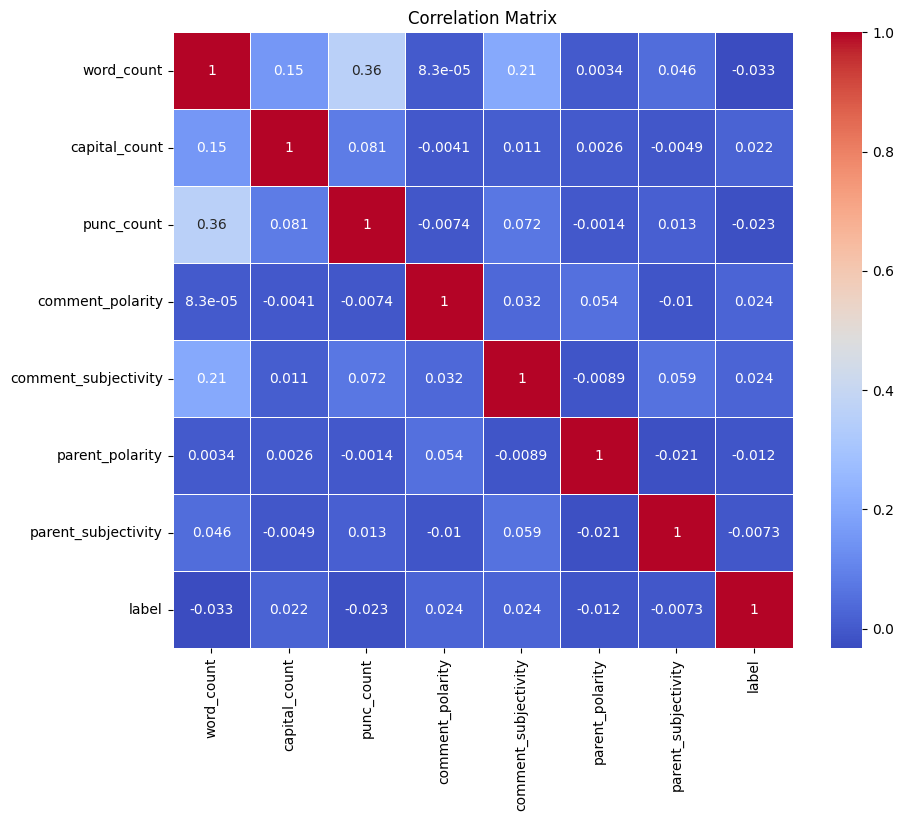

word_count              0.010077
comment_subjectivity    0.005829
punc_count              0.005228
comment_polarity        0.000757
capital_count           0.000000
parent_polarity         0.000000
parent_subjectivity     0.000000
dtype: float64


In [ ]:
data = sentiment[['word_count', 'capital_count', 'punc_count', 'comment_polarity', 'comment_subjectivity', 'parent_polarity', 'parent_subjectivity','label']]

# Pearson Correlation
correlation_matrix = data.corr()
print(correlation_matrix['label'].drop('label'))

# Visualize Correlation
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

# Mutual Information
X = data.drop(columns=['label'])
y = data['label']
X_encoded = pd.get_dummies(X, drop_first=True)
mutual_info = mutual_info_classif(X_encoded, y)
mutual_info_series = pd.Series(mutual_info, index=X_encoded.columns)
print(mutual_info_series.sort_values(ascending=False))

**FINAL ONE**

In [20]:
from sklearn.model_selection import KFold

X_train = sentiment.drop(columns = ['label', 'parent_comment'])
y_train = sentiment['label']

kf = KFold(n_splits=5, shuffle=True, random_state=123)
acc = []
prec = []
rec = []
f1 = []

for train_i, val_i in kf.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_i], X_train.iloc[val_i]  # numpy array
    y_train_fold, y_val_fold = y_train.iloc[train_i], y_train.iloc[val_i]  # pd df

    # Apply Tf-idf vectors on comments
    tfidf = TfidfVectorizer(min_df=15)
    train_tfidf = tfidf.fit_transform(X_train_fold["comment"])
    val_tfidf = tfidf.transform(X_val_fold["comment"])

    X_train_tfidf = hstack([csr_matrix(X_train_fold.drop(['comment'], axis=1).values), train_tfidf])
    X_val_tfidf = hstack([csr_matrix(X_val_fold.drop(['comment'], axis=1).values), val_tfidf])

    # Scale features before applying PCA
    scaler = StandardScaler()
    X_train_tfidf_scaled = scaler.fit_transform(X_train_tfidf.toarray())
    X_val_tfidf_scaled = scaler.transform(X_val_tfidf.toarray())

    # Apply PCA
    pca = PCA(n_components=0.95)
    X_train_pca = pca.fit_transform(X_train_tfidf_scaled)
    X_val_pca = pca.transform(X_val_tfidf_scaled)

    # Train KNN model
    knn = KNeighborsClassifier(n_neighbors=10)
    knn.fit(X_train_pca, y_train_fold)
    preds = knn.predict(X_val_pca)

    # Collect evaluation metrics
    acc.append(accuracy_score(y_val_fold, preds))
    prec.append(precision_score(y_val_fold, preds))
    rec.append(recall_score(y_val_fold, preds))
    f1.append(f1_score(y_val_fold, preds))


In [21]:
print(f'Mean accuracy: {np.mean(acc)}')
print(f'Mean precision: {np.mean(prec)}')
print(f'Mean recall: {np.mean(rec)}')
print(f'Mean f1: {np.mean(f1)}')

Mean accuracy: 0.6065158718479524
Mean precision: 0.6721787544946812
Mean recall: 0.7125750372202846
Mean f1: 0.691776857446041


In [ ]:
from sklearn.model_selection import KFold

X_train_b = bigram.drop(columns = ['label', 'parent_comment'])
y_train_b = bigram['label']

kf = KFold(n_splits=5, shuffle=True, random_state=123)
acc_b = []
prec_b = []
rec_b = []
f1_b = []

for train_i, val_i in kf.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_i], X_train.iloc[val_i]  # numpy array
    y_train_fold, y_val_fold = y_train.iloc[train_i], y_train.iloc[val_i]  # pd df

    # Apply Tf-idf vectors on comments
    tfidf = TfidfVectorizer(min_df=15)
    train_tfidf = tfidf.fit_transform(X_train_fold["comment"])
    val_tfidf = tfidf.transform(X_val_fold["comment"])

    X_train_tfidf = hstack([csr_matrix(X_train_fold.drop(['comment'], axis=1).values), train_tfidf])
    X_val_tfidf = hstack([csr_matrix(X_val_fold.drop(['comment'], axis=1).values), val_tfidf])

    # Scale features before applying PCA
    scaler = StandardScaler()
    X_train_tfidf_scaled = scaler.fit_transform(X_train_tfidf.toarray())
    X_val_tfidf_scaled = scaler.transform(X_val_tfidf.toarray())

    # Apply PCA
    pca = PCA(n_components=0.95)
    X_train_pca = pca.fit_transform(X_train_tfidf_scaled)
    X_val_pca = pca.transform(X_val_tfidf_scaled)

    # Train KNN model
    knn = KNeighborsClassifier(n_neighbors=10)
    knn.fit(X_train_pca, y_train_fold)
    preds = knn.predict(X_val_pca)

    # Collect evaluation metrics
    acc_b.append(accuracy_score(y_val_fold, preds))
    prec_b.append(precision_score(y_val_fold, preds))
    rec_b.append(recall_score(y_val_fold, preds))
    f1_b.append(f1_score(y_val_fold, preds))

Feature selection using correlation coefficient is not very effective as corerlation coefficient between any of the 2 different variables are very low.

tfidf

In [ ]:
from sklearn.model_selection import train_test_split

# Separate features and target
X = sentiment.drop(columns=['label'])
y = sentiment['label']

tfidf = TfidfVectorizer(min_df = 15)
X_tfidf = tfidf.fit_transform(X['comment'])
X_numeric = X.drop(columns=['comment', 'parent_comment'])
X = hstack([csr_matrix(X_numeric.values), X_tfidf])

# Standardize the features
scaler = StandardScaler(with_mean=False)
X_scaled = scaler.fit_transform(X)

# Convert the sparse matrix to a dense format
X_dense = X_scaled.toarray()

# Initialize PCA
pca = PCA(n_components=0.99)  # Keep 99% of the variance
X_pca = pca.fit_transform(X_dense)

In [ ]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, roc_auc_score, accuracy_score
from sklearn.metrics import f1_score

# Train KNN
knn = KNeighborsClassifier(n_neighbors=25)
knn.fit(X_train, y_train)

# Make predictions
y_pred = knn.predict(X_test)
y_pred_proba = knn.predict_proba(X_test)[:, 1]

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')
precision = precision_score(y_test, y_pred)
print(f'Precision: {precision:.4f}')
auc = roc_auc_score(y_test, y_pred_proba)
print(f'AUC: {auc:.4f}')
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1:.4f}')
# n=1: Acc = 0.5915, precision = 0.6680, auc = 0.5630
# n=5: Acc = 0.6102, pre = 0.6671, auc = 0.6098, f1 = 0.7033
# n=10: Acc = 0.6093, pre = 0.6766, auc = 0.6203, f1 = 0.6933
# n=15: Acc = 0.6256, pre = 0.6630, auc = 0.6263, f1 = 0.7283
# n=25: Acc = 0.6291, pre = 0.6588, auc = 0.6267, f1 = 0.7367

Accuracy: 0.6291
Precision: 0.6588
AUC: 0.6267
F1 Score: 0.7367


In [ ]:
# @title Ignore (Takes too long)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, roc_auc_score, accuracy_score

# Range of neighbors to evaluate
neighbors_range = range(1, 21)

# Lists to store metrics
accuracies = []
precisions = []
aucs = []

for n_neighbors in neighbors_range:
    # Train KNN
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(X_train, y_train)

    # Make predictions
    y_pred = knn.predict(X_test)
    y_pred_proba = knn.predict_proba(X_test)[:, 1]

    # Evaluate
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)

    # Store the metrics
    accuracies.append(accuracy)
    precisions.append(precision)
    aucs.append(auc)

# Plotting the results
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.plot(neighbors_range, accuracies, marker='o')
plt.title('Accuracy vs. Number of Neighbors')
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.xticks(neighbors_range)

plt.subplot(1, 3, 2)
plt.plot(neighbors_range, precisions, marker='o', color='orange')
plt.title('Precision vs. Number of Neighbors')
plt.xlabel('Number of Neighbors')
plt.ylabel('Precision')
plt.xticks(neighbors_range)

plt.subplot(1, 3, 3)
plt.plot(neighbors_range, aucs, marker='o', color='green')
plt.title('AUC vs. Number of Neighbors')
plt.xlabel('Number of Neighbors')
plt.ylabel('AUC')
plt.xticks(neighbors_range)

plt.tight_layout()
plt.show()

tfidf with bigram

In [ ]:
from sklearn.model_selection import train_test_split

# Separate features and target
X_b = bigram.drop(columns=['label', 'comment_id'])
y_b = bigram['label']

tfidf = TfidfVectorizer(min_df = 15)
X_tfidf_b = tfidf.fit_transform(X_b['comment'])
X_numeric_b = X_b.drop(columns=['comment', 'parent_comment'])
X_b = hstack([csr_matrix(X_numeric_b.values), X_tfidf_b])

# Standardize the features
scaler = StandardScaler(with_mean=False)
X_scaled_b = scaler.fit_transform(X_b)

# Convert the sparse matrix to a dense format
X_dense_b = X_scaled_b.toarray()

# Initialize PCA
pca = PCA(n_components=0.99)  # Keep 99% of the variance
X_pca_b = pca.fit_transform(X_dense_b)

In [ ]:
# Split the dataset
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_pca_b, y_b, test_size=0.2, random_state=42)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, roc_auc_score, accuracy_score
from sklearn.metrics import f1_score

# Train KNN
knn = KNeighborsClassifier(n_neighbors=45)
knn.fit(X_train_b, y_train_b)

# Make predictions
y_pred_b = knn.predict(X_test_b)
y_pred_proba_b = knn.predict_proba(X_test_b)[:, 1]

# Evaluate
accuracy = accuracy_score(y_test_b, y_pred_b)
print(f'Accuracy: {accuracy:.4f}')
precision = precision_score(y_test_b, y_pred_b)
print(f'Precision: {precision:.4f}')
auc = roc_auc_score(y_test_b, y_pred_proba_b)
print(f'AUC: {auc:.4f}')
f1 = f1_score(y_test_b, y_pred_b)
print(f'F1 Score: {f1:.4f}')
# n=1: Acc = 0.6007, pre = 0.6765, auc = 0.5695, f1 = 0.6850
# n=5: Acc = 0.6152, pre = 0.6729, auc = 0.6127, f1 = 0.7090
# n=25: Acc = 0.6241 pre = 0.6756, auc = 0.6337, f1 = 0.7189
# n=45: Acc = 0.6095, pre = 0.6835, auc = 0.6216, f1 = 0.6918

Accuracy: 0.6095
Precision: 0.6835
AUC: 0.6216
F1 Score: 0.6918


In [ ]:
train_bert = pd.read_pickle('/content/drive/My Drive/bert_embeddings_train.pkl')
test_bert = pd.read_pickle('/content/drive/My Drive/bert_embeddings_test.pkl')

In [ ]:
train_bert.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment,bert_comment,bert_parent_comment
0,0,nc and nh.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"yeah, i get that argument. at this point, i'd ...","[[-0.25036287, -0.2853816, 0.06431354, -0.0052...","[[0.002192806, 0.015306597, 0.051709518, 0.006..."
10,0,i think a significant amount would be against ...,ThisIsNotKimJongUn,politics,92,92,0,2016-09,2016-09-20 17:53:52,i bet if that money was poured into college de...,"[[0.15192702, 0.057156026, -0.12133491, 0.1292...","[[0.027917998, -0.052943494, -0.012402343, 0.1..."
17,0,because it's what really bothers him... and it...,kozmo1313,politics,15,-1,-1,2016-12,2016-12-26 20:10:45,he actually acts like a moody emo girl on twit...,"[[-0.04410069, 0.11008257, 0.21541062, -0.0712...","[[0.17864023, 0.24812481, 0.18442883, -0.04454..."
22,0,conservatism as an ideology is for sure a reac...,MayorMcCheese59,politics,1,-1,-1,2016-12,2016-12-24 00:04:06,"i still doubt that ""all conservatives stand fo...","[[-0.15151507, -0.005664783, -0.06255424, -0.1...","[[-0.21756738, 0.042341508, -0.06683649, 0.047..."
23,0,"maybe not control, but certainly that is evide...",SunTzu-,politics,1,-1,-1,2016-10,2016-10-13 20:48:14,today russian media tweeted out that wikileaks...,"[[0.016160298, 0.020996766, -0.10356138, 0.174...","[[0.20239735, -0.25236383, 0.10310403, 0.18064..."


In [ ]:
test_bert.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment,bert_comment,bert_parent_comment
0,0,actually most of her supporters and sane peopl...,Quinnjester,politics,3,3,0,2016-09,1473569605,hillary's surrogotes told to blame media for '...,"[[0.2728637, -0.17651713, 0.13503198, 0.139170...","[[0.11118117, -0.12834927, 0.066489935, 0.0073..."
6,0,"""four score and seven gropes ago...""",Kanzisbuddy,politics,-1,-1,-1,2016-10,1477159141,gettysburg address: the first 100 days of a tr...,"[[0.03881643, -0.106122, 0.26482913, -0.057139...","[[-0.1293082, -0.0901207, 0.18084918, -0.03291..."
9,0,"yes, because making sure the party in power do...",rydan,politics,-1,-1,0,2016-09,1472954129,"he's already encouraged his supporters to ""obs...","[[-0.05180453, -0.12974288, 0.06564042, 0.1824...","[[0.15203327, -0.10598624, 0.24455981, 0.03325..."
33,0,"yes you will, democrats cave and compromise ev...",o0flatCircle0o,politics,1,-1,-1,2016-11,1479345713,new top judiciary dem warns trump: we won't fo...,"[[-0.10038751, -0.13003553, 0.2965448, 0.18923...","[[0.041260313, -0.3143371, 0.06217872, 0.21281..."
54,0,you would think that as much as everyone blame...,Old_Army90,politics,3,-1,-1,2016-11,1480531475,this is pure victim-blaming. after the republi...,"[[0.042104598, 0.12200161, -0.00376096, 0.1008...","[[-0.36502808, -0.2924202, -0.05986113, 0.1534..."


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, roc_auc_score, accuracy_score
from sklearn.metrics import f1_score

# Convert embeddings and labels to appropriate format
X_train_bert_list = list(train_bert['bert_comment'])
X_train_bert_list = np.array(X_train_bert_list).reshape(len(X_train_bert_list), -1)
X_train_bert = pd.DataFrame(X_train_bert_list)
X_test_bert_list = list(test_bert['bert_comment'])
X_test_bert_list = np.array(X_test_bert_list).reshape(len(X_test_bert_list), -1)
X_test_bert = pd.DataFrame(X_test_bert_list)
y_train_bert = train_bert['label']
y_test_bert = test_bert['label']

# Initialize KNN with a chosen number of neighbors and distance metric
knn = KNeighborsClassifier(n_neighbors=35, metric='cosine')

# Train the model
knn.fit(X_train_bert, y_train_bert)

# Make predictions on the test set
y_pred_bert = knn.predict(X_test_bert)
y_prob_bert = knn.predict_proba(X_test_bert)[:, 1]  # Probability estimates for the positive class
# Evaluate the model
accuracy = accuracy_score(y_test_bert, y_pred_bert)
precision = precision_score(y_test_bert, y_pred_bert)
auc = roc_auc_score(y_test_bert, y_prob_bert)
f1 = f1_score(y_test_bert, y_pred_bert)

In [ ]:
# n=5: acc = 0.6885, pre = 0.7101, auc = 0.7184, f1 = 0.7672
# n=15: 0.703157487548958 0.7062582221386957 0.757833256298976 0.7860006274619166
# n=25: acc = 0.7043, pre = 0.7017, auc = 0.7652, f1 = 0.7898
# n=30: 0.7060587012233451 0.7077731223813395 0.766268572743855 0.7882987985373499
# n=35: 0.7011749915381268 0.6969423377874082 0.7672445283843917 0.7893516940486741
# n=45: 0.6982254243024999 0.6927743086529884 0.7686838359056382 0.788719997291716
print(accuracy, precision, auc, f1)

0.7011749915381268 0.6969423377874082 0.7672445283843917 0.7893516940486741
